<a href="https://colab.research.google.com/github/vithushanms/makemore-language-model/blob/main/%5BLanguage_Models%5D_makemore_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
#if cloud
from google.colab import drive
drive.mount('/content/drive')
dataFilePath = '/content/drive/My Drive/Publications/Neural Networks Research/makemore: next char prediction language model/names.txt'
words = open(dataFilePath, 'r').read().splitlines() 

Mounted at /content/drive


In [4]:
len(words)

32033

In [48]:
# encode chars in the words to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
[0] * 3

[0, 0, 0]

In [49]:
# build the dataset

'''
build the dataset while having the block_size (the number of chars we are going to input at a time) as 3
'''
block_size = 3 
X, Y = [], []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


X.shape = 32, 3 as the number of inputs are 32 and each have 3 charector input
Y.shape = 32, 1 as the number of outcome are 32 and for each respective inputs of 3 charactor there will be one output

As a next step we should encode the dataset X to some sort of format that should be light weight at the same time have the context. 

If we use the one hot encoding this would work for this particular case as it's only 27 distinct charecter we have in our dataset. but if we take large language models posibily there would be more than a billion distict words makes that diemention to the input set. Therefore we need to scale it down to a smaller diemention without loosing the quality of the prediction. So for that and the following reasons we should scale down the data.

*   Sparsity: One-hot encoded vectors are sparse, with only one element being 1 and the rest being 0. This can lead to high memory usage, especially for large vocabularies, as each word requires a vector of the size of the vocabulary.
*   Computational complexity: Since one-hot encoded vectors are high-dimensional, matrix multiplications and other operations in the model become computationally expensive. By reducing the dimensionality, you can significantly speed up training and inference.
* No semantic information: One-hot encoded vectors don't capture any semantic relationships between words, as they are orthogonal to each other. Word embeddings, on the other hand, are dense vector representations that capture semantic relationships, making it easier for the model to learn and generalize from the data.
* Poor generalization: One-hot encoding does not support handling out-of-vocabulary words or handling new words that were not seen during training. Word embeddings can help in this regard by generating embeddings for previously unseen words based on their morphological or contextual similarities to known words.
* Difficulty in capturing context: One-hot encoded vectors don't capture context information effectively. Word embeddings, especially when used in combination with more advanced techniques like transformers, can capture long-range dependencies and contextual information, enabling the model to better understand and generate coherent sequences of text.



In [75]:
# we can use the matrix multiplication to scale it down. ex (32,27) * (27,2) = (32,2) 
#Also this is going to be the first layer / input layer of the MLP
C = torch.rand(27,2, requires_grad=True)
#example with a one hot encoding of 5
five_en = torch.nn.functional.one_hot(torch.tensor(5), num_classes=27).float()
(five_en @ C)


tensor([0.0311, 0.9306], grad_fn=<SqueezeBackward3>)

In [76]:
#apperently this is same as what we are going to get by the integer representation itself|
C[5]

tensor([0.0311, 0.9306], grad_fn=<SelectBackward0>)

So we can dierectly use indexing here

In [77]:
# we can index the whole data set at one go
C[X].shape

torch.Size([32, 3, 2])

This is resulting with 32, 3, 2 because we have 32 lines of inputs and each input has 3 character and each character is encoded to 2 diemention instead of 27

In [78]:
emb = C[X]

But at some point we need to concatinate the 3 character encodings as we need to pass them all together to the inputs to next layer of the model

In [69]:
# we can use torch.cat
torch.cat([emb[: , 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [79]:
# we can use view which is the most efficent way
emb.view(32,6).shape

torch.Size([32, 6])

view() is used to reshape a tensor without altering its underlying data. It returns a new tensor with the specified dimensions that shares the same data with the original tensor. The primary goal of view() is to change the dimensions of a tensor to match the input or output requirements of neural network layers or other operations.

torch.cat() is used to concatenate multiple tensors along a specified dimension. This operation combines the input tensors into a single larger tensor, effectively "stacking" them along the chosen axis. The input tensors must have the same shape along all dimensions except for the one being concatenated.

However in this spesific scenario the data arrangement is going to the same in both the cases as we are effectivly slicing the input. But view is slightly efficent as it's just a reshape operation performed in the same tensor rather than creating a tensor and copying the data to the new diemension in torch.cat

In [82]:
torch.cat([emb[: , 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.0311, 0.9306],
        [0.7428, 0.8382, 0.0311, 0.9306, 0.3676, 0.3536],
        [0.0311, 0.9306, 0.3676, 0.3536, 0.3676, 0.3536],
        [0.3676, 0.3536, 0.3676, 0.3536, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.5706, 0.9809],
        [0.7428, 0.8382, 0.5706, 0.9809, 0.1455, 0.0148],
        [0.5706, 0.9809, 0.1455, 0.0148, 0.8871, 0.8455],
        [0.1455, 0.0148, 0.8871, 0.8455, 0.1168, 0.8868],
        [0.8871, 0.8455, 0.1168, 0.8868, 0.8871, 0.8455],
        [0.1168, 0.8868, 0.8871, 0.8455, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.9163, 0.0395, 0.1168, 0.8868],
        [0.9163, 0.0395, 0.1168, 0.8868, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.742

In [81]:
emb.view(32,6)

tensor([[0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.0311, 0.9306],
        [0.7428, 0.8382, 0.0311, 0.9306, 0.3676, 0.3536],
        [0.0311, 0.9306, 0.3676, 0.3536, 0.3676, 0.3536],
        [0.3676, 0.3536, 0.3676, 0.3536, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.5706, 0.9809],
        [0.7428, 0.8382, 0.5706, 0.9809, 0.1455, 0.0148],
        [0.5706, 0.9809, 0.1455, 0.0148, 0.8871, 0.8455],
        [0.1455, 0.0148, 0.8871, 0.8455, 0.1168, 0.8868],
        [0.8871, 0.8455, 0.1168, 0.8868, 0.8871, 0.8455],
        [0.1168, 0.8868, 0.8871, 0.8455, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.9163, 0.0395, 0.1168, 0.8868],
        [0.9163, 0.0395, 0.1168, 0.8868, 0.9163, 0.0395],
        [0.7428, 0.8382, 0.7428, 0.8382, 0.7428, 0.8382],
        [0.742

A Multilayer Perceptron (MLP) is a type of artificial neural network that can be used for language modeling tasks. The following are some of the hyperparameters that can be adjusted in an MLP for language modeling:

1. Architecture: The number of hidden layers and the number of neurons in each layer can be adjusted. Increasing the number of hidden layers and neurons can increase the capacity of the model, but also increase the risk of overfitting.

2. Activation Function: The activation function used in each layer can be adjusted. Common choices include ReLU, sigmoid, and tanh.

3. Learning Rate: The learning rate determines the step size used to update the model's parameters during training. A too-high learning rate can cause the model to converge slowly or not at all, while a too-low learning rate can cause the model to converge too slowly.

4. Momentum: Momentum is a hyperparameter used in gradient descent optimization algorithms to speed up convergence. It adds a fraction of the update vector of the past time step to the current update vector.

5. Regularization: Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. Common choices include L1 and L2 regularization, and dropout.

6. Batch Size: The batch size determines the number of samples used in one iteration of training. Larger batch sizes can lead to faster training, but may also require more memory.

7. Epochs: The number of training epochs determines how many times the model will see the entire training dataset. More epochs can lead to better model performance, but also increase the risk of overfitting.

These are some of the most common hyperparameters that can be adjusted in an MLP for language modeling. The optimal values for these hyperparameters depend on the specific task and dataset, and often require experimentation to determine.

These hyperparameter can be optimized mostly by the trial and errors during the training 

In [84]:
#create hidden layer. having 100 neurons initially and adding tanh as an activation function
W1 = torch.randn((6,100), requires_grad=True)
b = torch.randn(100, requires_grad=True)
out_1 = emb.view(32,6) @ W1 + b
out_h = torch.tanh(out_1)

In [24]:
out_h.shape

torch.Size([32, 100])

In [85]:
#create final layer. we are using the softmax for activation function as the expecation to get a probability of each character in 27
W2 = torch.randn((100,27) , requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
logits = out_h @ W2 + b2  
#perform softmax
counts = torch.exp(logits)
counts.shape
prob = counts / counts.sum(1, keepdim=True)

Emphasize differences: Exponentiating logits makes the differences between large and small logits more pronounced, causing the softmax function to produce more distinct probabilities. This property is helpful in tasks like classification, where you want the model to be more confident in its predictions.

Non-negative probabilities: Exponentiating logits ensures that the resulting probabilities are non-negative, as the exponential function e^x is always positive for any x. This is important because probabilities should always be non-negative by definition.

Normalization: After exponentiating logits, they are normalized by dividing each exponentiated logit by the sum of all exponentiated logits. This normalization step ensures that the resulting probabilities sum up to 1, which is a requirement for a valid probability distribution.

In [28]:
prob.shape

torch.Size([32, 27])

In [87]:
for i in range(len(Y[:2])):
  iy = Y[i].item()
  print(f'---- y actual : {itos[iy]} --> {iy} ')
  print('---- predicted probabilities : ', prob[i])
  print(f'---- predicted probability of {itos[iy]} {prob[i][iy]} ')

---- y actual : e --> 5 
---- predicted probabilities :  tensor([6.9951e-11, 1.6316e-02, 2.8647e-17, 2.4492e-15, 1.7881e-14, 6.5998e-07,
        2.1961e-09, 7.3027e-09, 8.0771e-10, 8.1496e-12, 2.2248e-10, 1.1416e-07,
        1.3668e-05, 6.7280e-04, 3.7874e-11, 3.8198e-14, 2.1196e-14, 1.3297e-17,
        4.6962e-09, 8.5355e-05, 4.8245e-13, 9.8291e-01, 1.3468e-12, 2.0143e-07,
        2.0065e-06, 1.1034e-16, 3.8128e-13], grad_fn=<SelectBackward0>)
---- predicted probability of e 6.599835273846111e-07 
---- y actual : m --> 13 
---- predicted probabilities :  tensor([6.5953e-10, 2.7786e-01, 6.4978e-14, 4.3258e-12, 1.1081e-12, 3.1555e-04,
        5.7238e-06, 1.7194e-06, 4.2561e-05, 1.4837e-06, 2.5292e-07, 2.4702e-04,
        1.3931e-02, 3.2893e-04, 8.8368e-08, 4.5034e-11, 5.5952e-12, 2.0089e-13,
        6.0867e-08, 8.5093e-03, 1.8957e-10, 6.9869e-01, 2.4772e-13, 6.3092e-05,
        2.6810e-06, 1.7398e-16, 6.8116e-11], grad_fn=<SelectBackward0>)
---- predicted probability of m 0.000328926718

In [90]:
#get the probability of y act from all the respective 32 input feature set 
prob[torch.arange(32), Y]

tensor([6.5998e-07, 3.2893e-04, 5.7530e-08, 9.9913e-01, 6.2100e-07, 3.8198e-14,
        3.2256e-01, 3.8683e-09, 9.7467e-08, 1.0452e-03, 9.9973e-01, 9.8216e-06,
        1.6316e-02, 2.5991e-13, 9.7221e-01, 9.5188e-04, 8.1496e-12, 1.1505e-02,
        1.0000e+00, 6.4453e-09, 2.0627e-04, 1.4718e-04, 4.6814e-02, 9.9988e-01,
        2.3657e-10, 8.5355e-05, 6.3206e-08, 4.6354e-13, 2.5934e-06, 1.6382e-06,
        9.7580e-01, 6.3726e-04], grad_fn=<IndexBackward0>)

In [92]:
#calculate the log likelyhood which is the loss
loss = nll = -prob[torch.arange(32),Y].log().mean() 
loss

tensor(11.2043, grad_fn=<NegBackward0>)

In [93]:
#parameter of the model
parameters = [C, W1, b, W2, b2]
sum(p.nelement() for p in parameters)

3481

cross_entropy is a built in feature within the pytorch that calculates the negative log likelyhood againt the Y actual after performing the softmax from the given logits. and as it's inbuilt, this is much more effiecent to use

In [94]:
#there is an internal impl in pytourch which calculates the loss directly
loss = F.cross_entropy(logits, Y)
loss

tensor(11.2043, grad_fn=<NllLossBackward0>)

In [36]:
# #forward
# emb = C[X]
# out_1 = emb.view(-1,6) @ W1 + b
# out_h = torch.tanh(out_1)
# logits = out_h @ W2 + b2  
# loss = torch.nn.functional.cross_entropy(logits, Y)
# loss

In [37]:
# #backward
# for p in parameters:
#   p.grad = None
# loss.backward()

# #update
# for p in parameters:
#   p.data += -0.5 * p.grad

In [38]:
for i in range(10):
  #forward
  emb = C[X]
  out_1 = emb.view(-1,6) @ W1 + b
  out_h = torch.tanh(out_1)
  logits = out_h @ W2 + b2  
  loss = torch.nn.functional.cross_entropy(logits, Y)
  #backward
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    p.data += -0.5 * p.grad

loss

tensor(1.5370, grad_fn=<NllLossBackward0>)

In [39]:
# load the full data

'''
build the dataset while having the block_size (the number of chars we are going to input at a time) as 3
'''
block_size = 3 
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape

torch.Size([228146, 3])

In [40]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn(27,2, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [41]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [42]:
stepi = []
lossi = []
lri = []
for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] 
  feed = emb.view(-1, 6);
  h = torch.tanh(feed @ W1 + b1)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

8.160412788391113


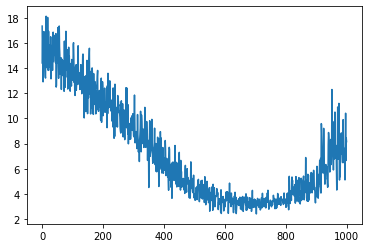

In [43]:
plt.plot(stepi, lossi)

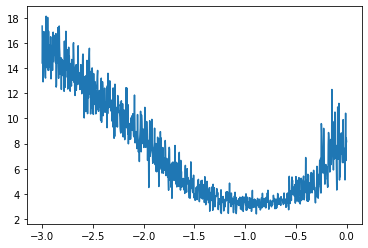

In [44]:
plt.plot(lri, lossi)

In [45]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(7.4026, grad_fn=<NllLossBackward0>)

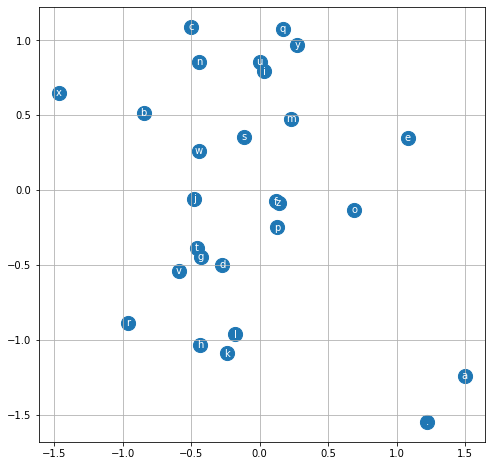

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [47]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] 
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

aldrryadalamamhesamhiadis.
alrem.
addem.
adrem.
llrryk.
adlem.
alrry.
drramalir.
llrryadis.
ldramamhuadir.
ldrryadir.
adlemamhehrem.
lrrxraaalrryd.
lrramal.
allradamhekremom.
alrrrwz.
alrryadim.
lalrrramamhuadim.
lremamhesamhemamhec.
lrrzzamremamhemom.
